# Rolling mean with CMIP6

## Import Python packages

In [27]:
import s3fs
import xarray as xr
import intake
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

## Open CMIP6 online catalog

In [5]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,517667
dcpp_init_year,60


## Search for data 

In [7]:
cat = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['so2'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,AERmon,so2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227


## Create a dictionary from the list of dataset

In [16]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:
list(dset_dict.keys())

['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']

## Open dataset

In [17]:
dset = dset_dict['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
dset

<xarray.Dataset>
Dimensions:    (lat: 192, lev: 70, lon: 288, member_id: 1, nbnd: 2, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lev        (lev) float64 -5.96e-06 -9.827e-06 -1.62e-05 ... -976.3 -992.6
    lev_bnds   (lev, nbnd) float32 dask.array<chunksize=(70, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    so2        (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 5, 70, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   20075.0
    case_id:                 4
    ...                      ...
    variable_id:             so2
    variant_info:            CMIP6 CESM2 hindcast (1850-2014) with high-top a...
    variant_label:           r1i1p1f1
    status:                  2019-11-05;created;by nhn2@columbia.edu
    intake_esm_varname:      ['so2']
    intake_esm_dataset_key:  CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn

In [80]:
dset.so2

,Array,Chunk
Bytes,30.66 GB,77.41 MB
Shape,"(1, 1980, 70, 192, 288)","(1, 5, 70, 192, 288)"
Count,793 Tasks,396 Chunks
Type,float32,numpy.ndarray


## Compute Weighted average

In [40]:
# Compute weights based on the xarray you pass
weights = np.cos(np.deg2rad(dset.lat))
weights.name = "weights"
# Compute weighted mean
var_weighted = dset.sel(lev=-1000, method="nearest").weighted(weights)
weighted_mean = var_weighted.mean(("lon", "lat"))

## Rolling mean
- Choose rolling time of 100

In [41]:
%%time
weighted_mean.load()

CPU times: user 2min 51s, sys: 51.6 s, total: 3min 42s
Wall time: 7min 24s


<xarray.Dataset>
Dimensions:    (member_id: 1, time: 1980)
Coordinates:
    lev        float64 -992.6
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Data variables:
    so2        (member_id, time) float64 5.779e-11 4.755e-11 ... 7.229e-10

In [42]:
%%time
dpmean = weighted_mean.chunk(chunks={'time': 100}).rolling({'time':100},
            min_periods=1,
            center=True
           ).mean()

CPU times: user 65.7 ms, sys: 2.29 ms, total: 68 ms
Wall time: 66.3 ms


## Visualize

CPU times: user 570 ms, sys: 113 ms, total: 683 ms
Wall time: 682 ms


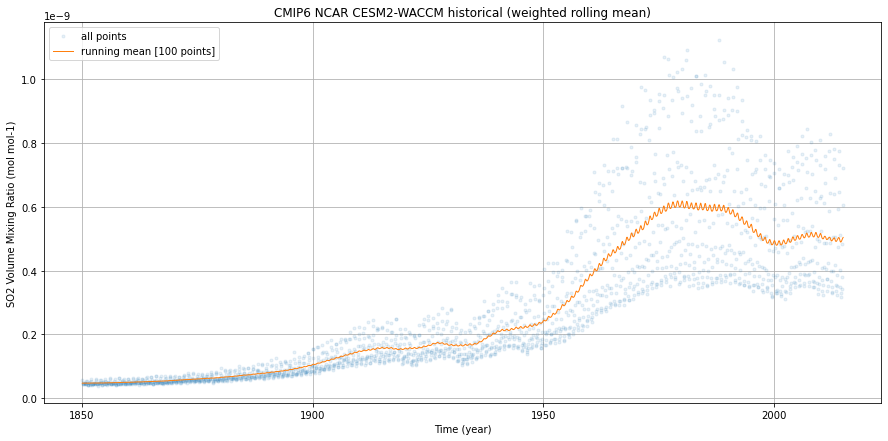

In [58]:
%%time
fig = plt.figure(1, figsize=[15,7])

ax = plt.subplot(1, 1, 1)

weighted_mean.so2.plot(ax=ax,
             marker='.',
             linewidth=0,
             label = 'all points',
             alpha=.1
            )

dpmean.so2.plot(ax=ax,
             marker='',
             linewidth=1,
             label = 'running mean [100 points]'
            )
ax.legend()
ax.grid()
ax.set_ylabel(dset.so2.attrs['long_name'] + ' (' + dset.so2.attrs['units'] + ')')
ax.set_xlabel('Time (year)')
ax.set_title('CMIP6 NCAR CESM2-WACCM historical (weighted rolling mean)')
plt.savefig('CMIP_NCAR_CESM2-WACCM_historical_weighted_rolling_mean.png')

## Save Results
To improve the reproducibility of our work (first for ourselves!), we need to keep track of all our work and ease its reuse. We will:
- Save this Jupyter notebook
- Save weighted mean
- Save rolling mean
- Save figure

We save intermediate results as netCDF files because they are small and ca be easily re-loaded (even if stored on cloud storage).

## Save results locally
- Useful for further analysis but can be lost if you close your JupyterLab or if there is any problem with your JupyterLab instance

In [60]:
weighted_mean.to_netcdf('CMIP_NCAR_CESM2-WACCM_historical_weighted_mean.nc')

In [61]:
dpmean.to_netcdf('CMIP_NCAR_CESM2-WACCM_historical_rolling_mean.nc')

## Save your results on NIRD (Norwegian infrastructure for Research Data)
- your credentials are in `$HOME/.aws/credentials` 
- check with your instructor to get the secret access key (replace XXX by the right key)

```
[default]
aws_access_key_id=forces2021-work
aws_secret_access_key=XXXXXXXXXXXX
aws_endpoint_url=https://forces2021.uiogeo-apps.sigma2.no/
```
<div class="alert alert-success alert-info">
    <b>It is important to save yoru results in a place that can last longer than a few days/weeks!</b>
</div>

In [64]:
import s3fs

In [69]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://forces2021.uiogeo-apps.sigma2.no/'
      })

## Set "remote" path (update annefou by your username) and save weighted mean as netCDF file

In [73]:
s3_path =  "s3://work/annefou/CMIP_NCAR_CESM2-WACCM_historical_weighted_mean.nc"
print(s3_path)

s3://work/annefou/CMIP_NCAR_CESM2-WACCM_historical_weighted_mean.nc


In [79]:
with fsg.open(s3_path, 'wb') as f:
    f.write(weighted_mean.to_netcdf(None))

## Save rolling mean to remote location (update annefou with your username)

In [75]:
s3_path =  "s3://work/annefou/CMIP_NCAR_CESM2-WACCM_historical_rolling_mean.nc"
print(s3_path)

s3://work/annefou/CMIP_NCAR_CESM2-WACCM_historical_rolling_mean.nc


In [76]:
with fsg.open(s3_path, 'wb') as f:
    f.write(dpmean.to_netcdf(None))

## Upload existing png file to remote s3 location

In [77]:
s3_path =  "s3://work/annefou/CMIP_NCAR_CESM2-WACCM_historical_weighted_rolling_mean.png"
print(s3_path)

s3://work/annefou/CMIP_NCAR_CESM2-WACCM_historical_weighted_rolling_mean.png


In [78]:
fsg.put('CMIP_NCAR_CESM2-WACCM_historical_weighted_rolling_mean.png', s3_path)